# Genetic algorithms

We are going to try and let evolution run its course by trying to approximate functions. This might be the least creative usage of a genetic algorithm, but is it is starkly appropriate for the topic of numerical methods.

Before moving on, we start by importing the dependencies.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import track
from sympy import *
from IPython.display import display, Math
import random
from math import floor

Now we are ready to define the DNA, which is at the core of any genetic algorithm. It is the DNA that is carried over from generation to generation, such that in the evolutionary course, the most fit individuals typically survive and pass there genes to the progeny. If we are to adapt the DNA to function approximation, we need to define a few specific things. Functions can be defined over an infinite range, which is difficult to fit. Instead we will try to approximate a function on a given range $[a, b]$, subdivided into $n$ discrete points. At the DNA level we also specify the number of terms the appoximated polynomials will have, and by extension, there will be twice as many genes,- half for the factors and half for the powers of the polynomial terms.

How do genes get carried over to a new generation? If we go with a model that requires two parents that will share their genes, then we want both of the parents to provide part of their genetic code. One of the simplest ways is to take a half of the genes of each parent, which we do in the <code>crossover</code> function.

Another staple of evolution is inherent randomization due to external factors. It is called mutation and without it no new traits would be introduced and a population will stagnate without any chance of adapting. We define randomized gene mutation in the <code>mutate</code> function.

In [13]:
class DNA:

    def __init__(self, a, b, n, num_terms) -> None:
        self.a = a
        self.b = b
        self.n = n
        self.num_terms = num_terms
        self.genes = []
        self.fitness = 0
        for _ in range(num_terms*2):
            self.genes.append(random.random())

    def crossover(self, partner):
        child = DNA(self.a, self.b, self.n, self.num_terms)
        midpoint = floor(random.randrange(0, len(self.genes)))
        for i in range(len(self.genes)):
            if (i < midpoint):
                child.genes[i] = self.genes[i]
            else:
                child.genes[i] = partner.genes[i]
        return child

    def mutate(self, mutation_rate):
        for i in range(len(self.genes)):
            if (random.random() < mutation_rate):
                self.genes[i] = random.random()
        

Having defined the DNA, which is the so-called genotype, we need its actual representation, or the phenotype. We define the Polynomial class that takes the DNA as its model and constructs a polynomial based on the genes. The purpose of the Polynomial class is to evaluate the polynomial at a given point and to calculate the fitness accordingly. By comparing the output of the original function (we are trying to approximate) with the output of an evolved polynomial at the same point, we can tell how close we are to the expected output. Based on this, the <code>calculate_fitness</code> function. This is where we take range $[a, b]$ subdivided into $n$ parts, iterate over each point and take the difference of the outputs. If the difference is $0$, we add a large number to the fitness score of the polynomial. Otherwise we add a number based on how close to zero the difference is. To be more precise, the fitness of a polynomial evaluated at a single point is:

$$
f = \frac{1}{(y - y')^2 + 1}
$$

In addition to the base Polynomial class, we define three specific implmentations. FifthDegreePolynomial fixes the powers of the terms up to the fifth power and randomizes the factors only. RandomFiveTermPolynomial, in addition to the factors, randomizes the powers, using the values passed from the genes.

RandomPolynomial is the most versatile implementation, letting the population contain polynomials with any number of terms for a specified size.

In [14]:
class Polynomial:

    def to_symbolic(self):
        x = Symbol('x')
        return self.eval_polynomial(x)
    
    def calculate_fitness(self, target_func):
        self.fitness = 0
        step = (self.dna.b - self.dna.a) / self.dna.n
        x = self.dna.a
        for _ in range(self.dna.n):
            diff = target_func(x) - self.eval_polynomial(x)
            try:
                self.fitness += 1/(diff**2 + 1.0)
            except ZeroDivisionError:
                self.fitness += 1000000
            x += step


class FifthDegreePolynomial(Polynomial):

    def __init__(self, dna) -> None:
        self.dna = dna
        self.fitness = 0

        self.t0_factor = round(np.interp(self.dna.genes[0], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t1_factor = round(np.interp(self.dna.genes[2], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t2_factor = round(np.interp(self.dna.genes[4], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t3_factor = round(np.interp(self.dna.genes[6], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t4_factor = round(np.interp(self.dna.genes[8], [0.0, 1.0], [-10.0, 10.0]), 5)

        self.t0_power = 1
        self.t1_power = 2
        self.t2_power = 3
        self.t3_power = 4
        self.t4_power = 5

    def eval_polynomial(self, x):
        result = (self.t0_factor * x**self.t0_power)
        result += (self.t1_factor * x**self.t1_power)
        result += (self.t2_factor * x**self.t2_power)
        result += (self.t3_factor * x**self.t3_power)
        result += (self.t4_factor * x**self.t4_power)
        return result
    

class RandomFiveTermPolynomial(Polynomial):

    def __init__(self, dna) -> None:
        self.dna = dna
        self.fitness = 0

        self.t0_factor = round(np.interp(self.dna.genes[0], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t1_factor = round(np.interp(self.dna.genes[2], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t2_factor = round(np.interp(self.dna.genes[4], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t3_factor = round(np.interp(self.dna.genes[6], [0.0, 1.0], [-10.0, 10.0]), 5)
        self.t4_factor = round(np.interp(self.dna.genes[8], [0.0, 1.0], [-10.0, 10.0]), 5)

        self.t0_power = int(np.interp(self.dna.genes[1], [0.0, 1.0], [1, 10]))
        self.t1_power = int(np.interp(self.dna.genes[3], [0.0, 1.0], [1, 10]))
        self.t2_power = int(np.interp(self.dna.genes[5], [0.0, 1.0], [1, 10]))
        self.t3_power = int(np.interp(self.dna.genes[7], [0.0, 1.0], [1, 10]))
        self.t4_power = int(np.interp(self.dna.genes[9], [0.0, 1.0], [1, 10]))

    def eval_polynomial(self, x):
        result = (self.t0_factor * x**self.t0_power)
        result += (self.t1_factor * x**self.t1_power)
        result += (self.t2_factor * x**self.t2_power)
        result += (self.t3_factor * x**self.t3_power)
        result += (self.t4_factor * x**self.t4_power)
        return result
    

class RandomPolynomial(Polynomial):

    def __init__(self, dna) -> None:
        if len(dna.genes) < 2:
            raise("Random polynomials should be provided with more than two genes.")

        if len(dna.genes) % 2 != 0:
            raise("Random polynomials should be constructed around an even number of genes.")
        
        self.dna = dna
        self.fitness = 0

        self.factors = []
        self.powers = []

        for i in range(len(self.dna.genes)-1):
            self.factors.append(round(np.interp(self.dna.genes[i], [0.0, 1.0], [-10.0, 10.0]), 5))
            self.powers.append(int(np.interp(self.dna.genes[i+1], [0.0, 1.0], [1, 10])))

    def eval_polynomial(self, x):
        result = 0
        for i in range(len(self.factors)):
            result += (self.factors[i] * x**self.powers[i])
        return result

With the DNA and the Polynomial classes at hand, we can move up one layer of abstraction. The Population class governs a whole family of polynomials at a time. Its purpose is to have its individual members to reproduce iteratively. In the <code>reproduction</code> function we select a pair of individuals that will merge their genes to create an offspring that will be a part of the new generation. This is done for the whole population. Mutation is also applied at the stage of when the child is created. Choosing the individuals for mating is accomplished on a weighted basis in the <code>weighted_selection</code> function. Once the fitness scores have been computed and normalized (see the <code>selection</code> function), we use them to pull random parents for reproduction. Having a higher fitness score given the individuals a higher chance to be picked.

In [15]:
class Population:

    def __init__(self, size, mutationRate, a, b, n, num_terms, PolyClass):
        self.mutationRate = mutationRate
        self.polynomials = []
        self.matingPool = []
        self.generations = 0
        self.PolyClass = PolyClass
        for _ in range(size):
            self.polynomials.append(PolyClass(DNA(a, b, n, num_terms)))

    def weighted_selection(self):
        index = 0
        start = random.random()
        while (start > 0):
            start -= self.polynomials[index].fitness
            index += 1
        index -= 1
        return self.polynomials[index]

    # normalize the fitness values
    def selection(self, f):
        totalFitness = 0
        for i in range(len(self.polynomials)):
            self.polynomials[i].calculate_fitness(f)
            totalFitness += self.polynomials[i].fitness
        for i in range(len(self.polynomials)):
            self.polynomials[i].fitness /= totalFitness

    def reproduction(self, f):
        nextPolynomials = []
        for _ in range(len(self.polynomials)):
            parentA = self.weighted_selection()
            parentB = self.weighted_selection()
            child = parentA.dna.crossover(parentB.dna)
            child.mutate(self.mutationRate)
            poly = self.PolyClass(child)
            poly.calculate_fitness(f)
            nextPolynomials.append(poly)
        self.polynomials = nextPolynomials
        self.generations += 1

    def get_max_fitness(self):
        max_fitness = -1
        index = -1
        for i in range(len(self.polynomials)):
            if self.polynomials[i].fitness > max_fitness:
                max_fitness = self.polynomials[i].fitness
                index = i
        return (max_fitness, index)

The overarching GeneticApproximation class wraps everything together.

In [16]:
class GeneticApproximation:

    def __init__(self, f, a, b, n, population_size, mutation_rate, num_terms=5, PolyClass=FifthDegreePolynomial):
        self.target_func = f
        self.population = Population(population_size, mutation_rate, a, b, n, num_terms, PolyClass)

    def update(self):
        self.population.selection(self.target_func)
        self.population.reproduction(self.target_func)

    def finalize(self):
        self.population.selection(self.target_func)


Next we define a few functions we will try to approximate with our polynomials.

In [17]:
def target_func1(x):
    return x

def target_func2(x):
    return 3*x**2

def target_func3(x):
    return 2*x**3

def target_func4(x):
    return np.sin(x)

Finally, the <code>run</code> function will iterate through many generations of polynomials and show the plot of the fitness of each generation as well as the best fitting polinomial from the final generation.

In [18]:
def run(PolyType, target_func):
    a = -10.0
    b = 10.0
    n = 50
    population_size = 64
    mutation_rate = 0.05
    num_terms = 5

    gen_approx = GeneticApproximation(
        target_func, 
        a, b, n, 
        population_size, 
        mutation_rate, 
        num_terms, 
        PolyType
    )

    fitness_result = []

    for _ in track(range(5000), description="Iterating"):
        gen_approx.update()
        
        fitness_result.append(gen_approx.population.get_max_fitness()[0])

    gen_approx.finalize()
    gen_approx.population.polynomials.sort(key=lambda x: x.fitness, reverse=True)

    x = np.arange(a, b, 0.1)
    y = target_func(x)

    fig, ax = plt.subplots()
    ax.plot(fitness_result, "C0", label="Best solution")
    ax.legend()
    ax.set_title("Fitness")
    ax.set_xlabel("Iteration #")
    plt.show()

    plt.xlim(-10, 10)
    plt.ylim(-1, 1)
    plt.plot(x, y, label="Target function")

    y_approx = gen_approx.population.polynomials[0].eval_polynomial(x)
    plt.plot(x, y_approx)

    plt.show()
    
    return gen_approx

In order to compare results we run the algorithm we each of the three implementation of the Polynomial class and for every test function. Paramets are as follows:

- Range $(a, b) = (-10, 10)$
- Number of steps $n = 50$
- Population size (# of polynomials in one generation) = 64
- Mutation rate = 5%
- Number of terms in a polynomial = 5
- Iterations (# of generations) = 5000

Output()

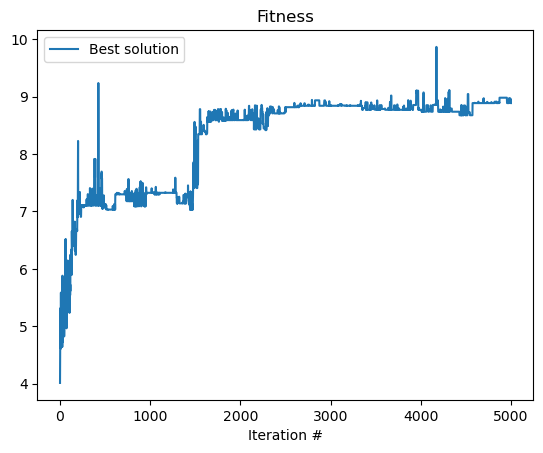

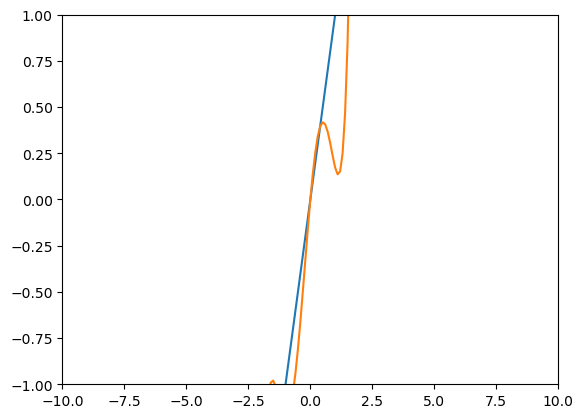

In [19]:
gen_approx = run(FifthDegreePolynomial, target_func1)

Output()

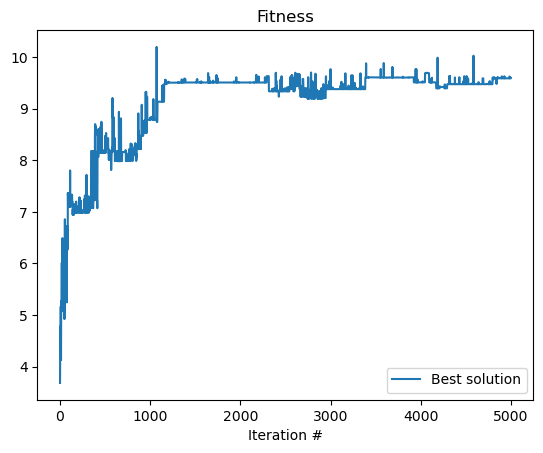

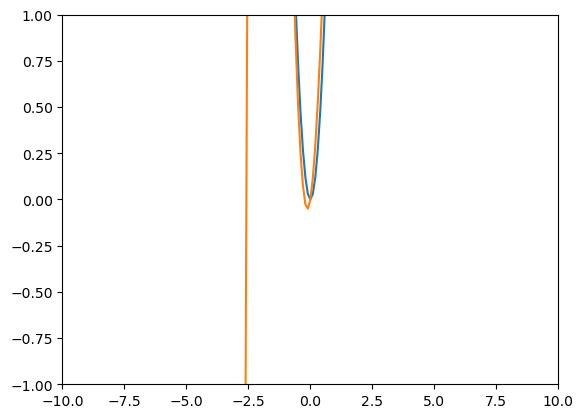

In [20]:
run(FifthDegreePolynomial, target_func2)

Output()

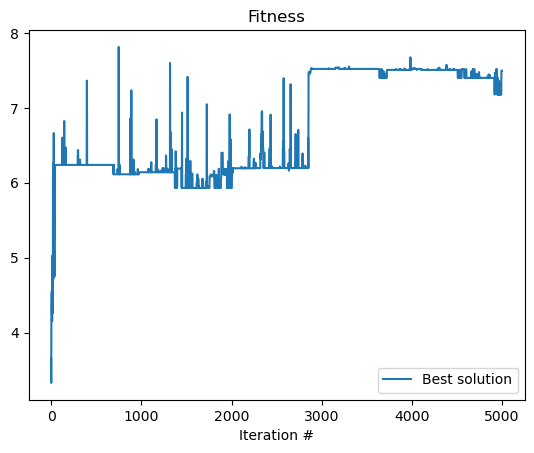

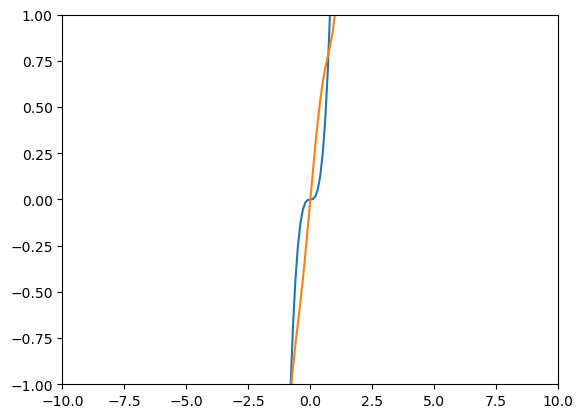

In [21]:
run(FifthDegreePolynomial, target_func3)

Output()

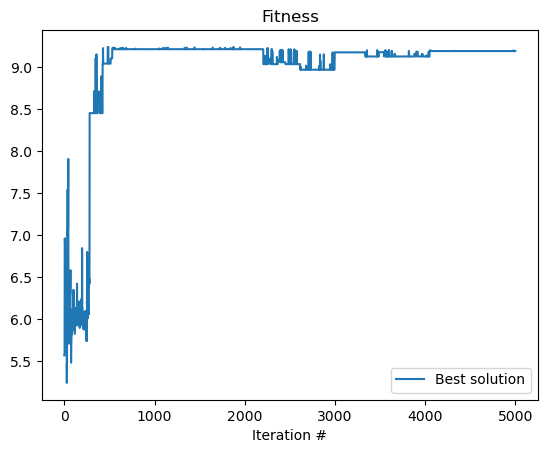

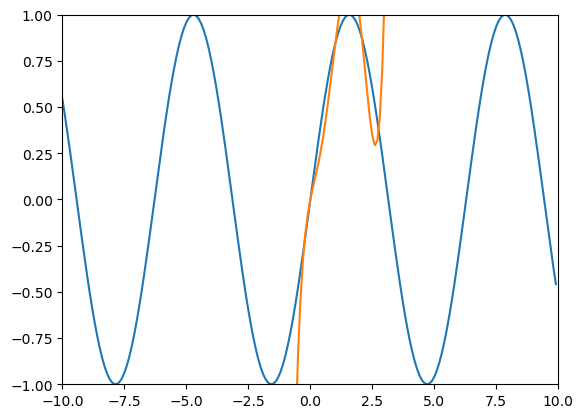

In [22]:
run(FifthDegreePolynomial, target_func4)

Output()

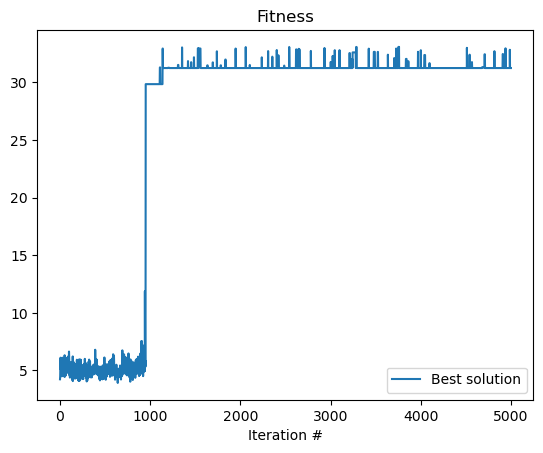

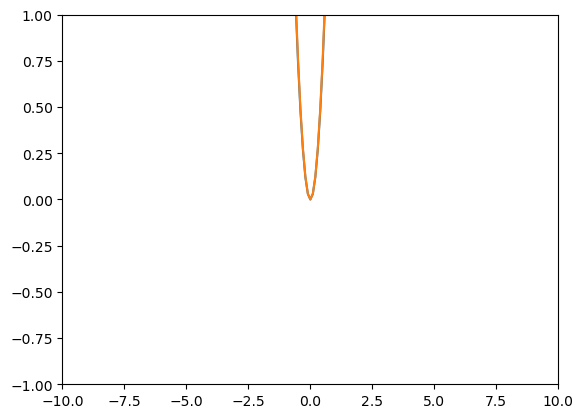

In [23]:
run(RandomFiveTermPolynomial, target_func2)

Output()

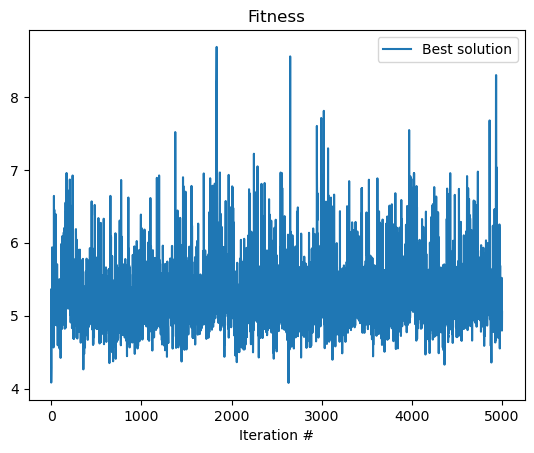

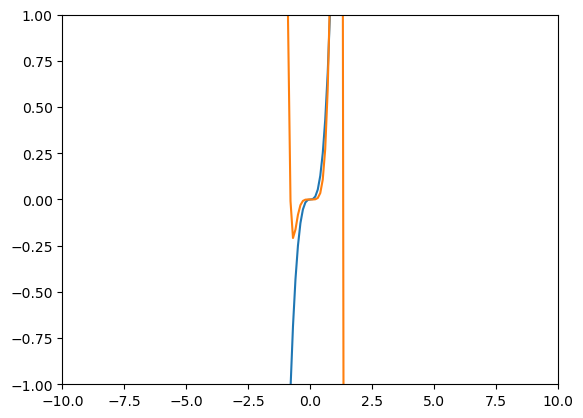

In [24]:
run(RandomFiveTermPolynomial, target_func3)

Output()

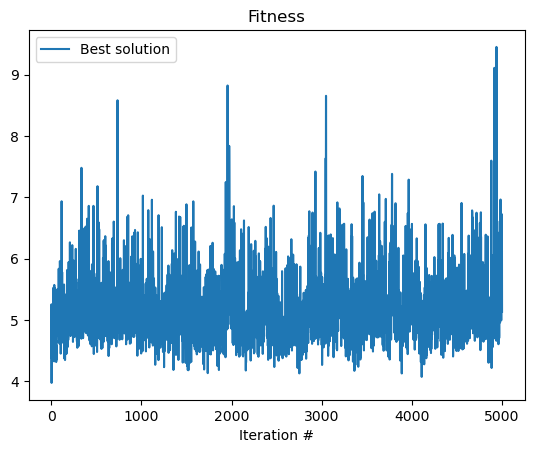

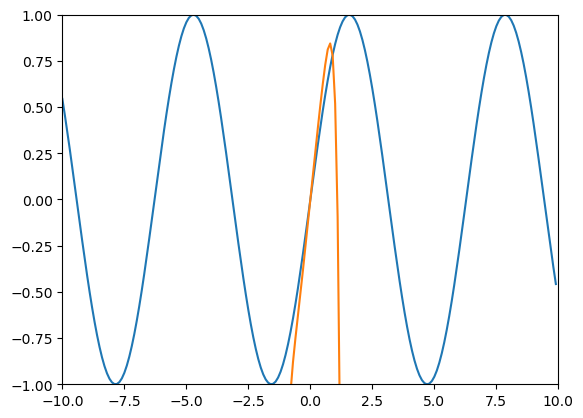

In [25]:
run(RandomFiveTermPolynomial, target_func4)

Output()

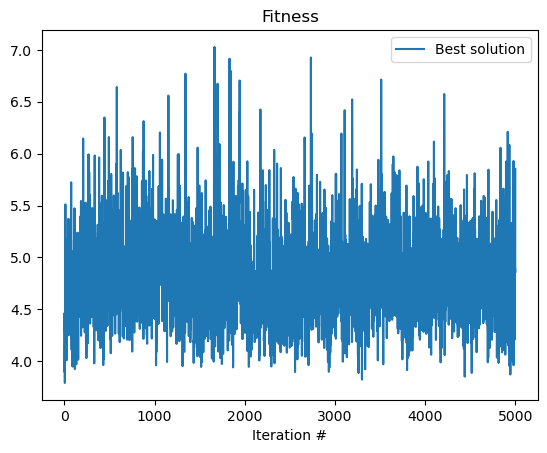

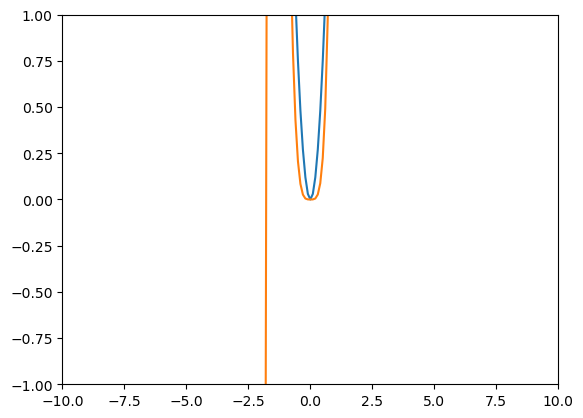

In [26]:
run(RandomPolynomial, target_func2)

Output()

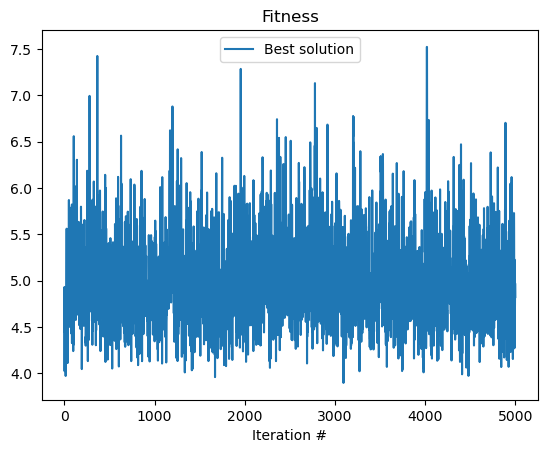

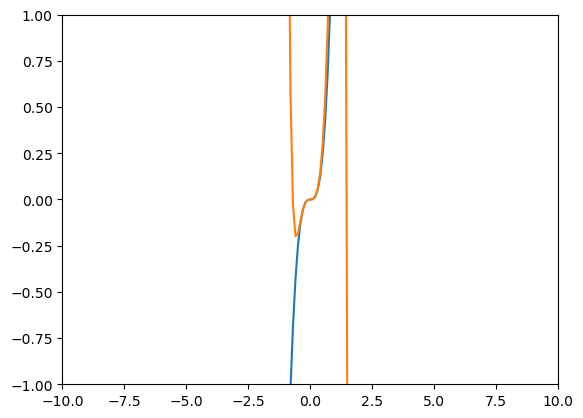

In [27]:
run(RandomPolynomial, target_func3)

Output()

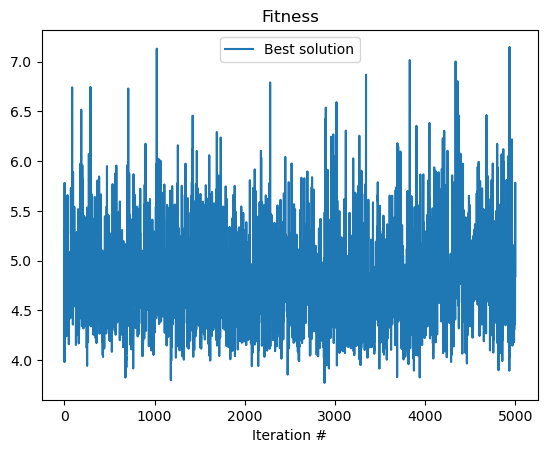

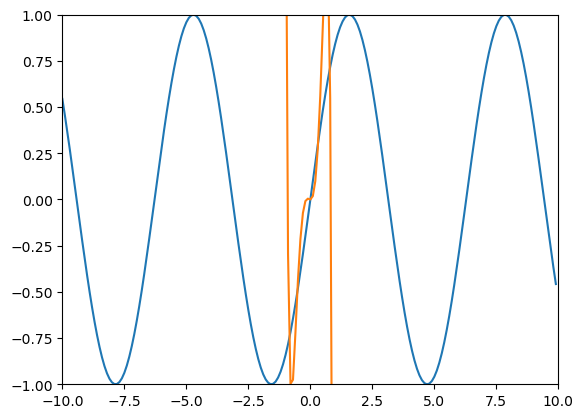

In [28]:
gen_approx = run(RandomPolynomial, target_func4)

Due to the nature of genetic algorithms and their inherent randomness, the results may vary from run to run. But the trials of the different polynomial implementations on different test functions should give a good idea of the limits of this approach of function approximation. In particular, periodic functions seem to handled the worst. Linear functions also don't appear well suited for randomized polynomials, while second and third degree polynomial functions are matched reasonably well.

To give an idea about the polynomials we have been generating, below are a few examples from the same generation of the RandomPolynomial type.

In [29]:
for i in range(10):
    display(Math(latex(gen_approx.population.polynomials[i].to_symbolic())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

References:

[1] The Nature of Code by Daniel Shiffman (https://natureofcode.com/genetic-algorithms/)

[2] My simple genetic algorithm in Python for polynomial curve fitting by Mario Tonin (https://mariotonin.me/2022/10/my-simple-genetic-algorithm-in-python-for-polynomial-curve-fitting/)